
# Baseline for the first problem of the SemSketches competition

**Main points of the algorithm:**

1) Semantic parsing is performed on a sentence with a context. Direct dependent predicates are masked.

2) With help of RuBert the predictions are made for the masked words.

3) The number of matches between the sketch and 1000 of Bert's predictions is evaluated.

In the end of this notebook sketches scores are vizualized and prediction is given in the expected format.

## Installing the required libraries and models


In this module, we will install DeepPavlov's RuBERT, the udpipe parser for the Russian language (russian-syntagrus-ud-2.5) and some other libraries.

### Load RuBERT (`model`, `tokenizer` vars)

In [ ]:
# set up torch `DEVICE` constant
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Russian Bert installation 
!wget -q --show-progress -c "http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz"
!tar -zxf rubert_cased_L-12_H-768_A-12_pt.tar.gz

BERT_MODEL_PATH = "rubert_cased_L-12_H-768_A-12_pt"
!cp {BERT_MODEL_PATH}/bert_config.json {BERT_MODEL_PATH}/config.json

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH)
model = BertForMaskedLM.from_pretrained(BERT_MODEL_PATH).to(DEVICE)

Some weights of the model checkpoint at rubert_cased_L-12_H-768_A-12_pt were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Load udpipe model (model_ud, pipeline vars)

In [ ]:
# Installing libraries for parsing
!wget -q --show-progress -c "https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/russian-syntagrus-ud-2.5-191206.udpipe"
UDPIPE_MODEL_PATH = "russian-syntagrus-ud-2.5-191206.udpipe"

russian-syntagrus-u 100%[===================>]  43.73M  18.6MB/s    in 2.3s    


In [ ]:
!pip install --progress-bar off --quiet transformers pymorphy2[fast] ufal.udpipe conllu graphviz

from ufal.udpipe import Model, Pipeline

model_ud = Model.load(UDPIPE_MODEL_PATH)
assert model_ud is not None, "Model failed to load"
pipeline = Pipeline(model_ud, 'generic_tokenizer', '', '', '')#

In [ ]:
from collections import OrderedDict
from tqdm.auto import tqdm
from copy import deepcopy
from pprint import pprint
import pandas as pd
import numpy as np
import torch 
import json
import itertools
from collections import defaultdict

import numpy as np  
import math
import pandas as pd

from conllu import parse
from nltk import DependencyGraph
from ufal.udpipe import Model, Pipeline

## Loading data

In [ ]:
# Downloading data from github
!git clone https://github.com/dialogue-evaluation/SemSketches.git
%cd SemSketches

Cloning into 'SemSketches'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 30 (delta 3), reused 29 (delta 2), pack-reused 0
Unpacking objects: 100% (30/30), done.
/content/SemSketches


In [ ]:
!ls data

dev  trial


We need to score our baseline, so only `trial` data split is relevant 

In [ ]:
!head -n 3 data/trial/*

==> data/trial/contexts_trial.data <==
{
    "trial.sent.rus.0": {
        "instance": "стать",

==> data/trial/sketches_trial.data <==
{
    "trial.sketch.rus.0": {
        "Sphere_Special": [

==> data/trial/trial.gold <==
{
    "trial.sent.rus.0": "trial.sketch.rus.8",
    "trial.sent.rus.1": "trial.sketch.rus.4",


In [ ]:
CONTEXTS_TRIAL = "data/trial/contexts_trial.data"
SKETCHES_TRIAL = "data/trial/sketches_trial.data"
TRIAL = "data/trial/trial.gold"

In [ ]:
# Let's look at sketches
sketches_dfs = dict()

sketches_trial_data = json.load(open(SKETCHES_TRIAL))
for sketch_name, sketch_columns_di in sketches_trial_data.items():
    colnames = [None] * len(sketch_columns_di)
    columns = [None] * len(sketch_columns_di)
    for colname, (col_ix, col_cells) in sketch_columns_di.items():
        colnames[col_ix] = colname
        columns[col_ix] = col_cells
    columns_ordered_dict = OrderedDict(zip(colnames, columns))
    sketches_dfs[sketch_name] = pd.DataFrame(columns_ordered_dict)

print('\n'.join(str(sketches_dfs).splitlines()[:12]))

{'trial.sketch.rus.0':     Sphere_Special                 Time  ...     ContrAgent Ch_Evaluation
0          в карты            в детстве  ...       с детьми       классно
1        в шахматы  на большой перемене  ...  с мальчишками       неплохо
2         в футбол           по вечерам  ...    с читателем       недурно
3  в азартные игры          каждый день  ...      с собакой   превосходно
4           в игры             допоздна  ...        с сыном      прилично
5         в прятки          в молодости  ...     с ребятами  замечательно

[6 rows x 6 columns], 'trial.sketch.rus.1':                      Locative_FinalPoint  ... Ch_EvaluationOfHumanTemperAndActivity
0                                к людям  ...                           скептически
1                           к литературе  ...                            критически
2                               к стихам  ...                            философски


In [ ]:
# Table with context "name", predicate (to be compared with sketch), 
# starting index of the predicate in the sentence,  starting index and sentence itself.
contexts_trial_df = pd.read_json(CONTEXTS_TRIAL).transpose()
contexts_trial_df.head(2)

,instance,start,end,sentence
trial.sent.rus.0,стать,63,68,"Старый я, песенка моя спета, и нет у меня боль..."
trial.sent.rus.1,вызвала,6,13,Но не вызвала


In [ ]:
# Dictionary with pairs: sentence - sketch
sent2sketch = json.load(open(TRIAL))
print(sent2sketch)

{'trial.sent.rus.0': 'trial.sketch.rus.8', 'trial.sent.rus.1': 'trial.sketch.rus.4', 'trial.sent.rus.2': 'trial.sketch.rus.6', 'trial.sent.rus.3': 'trial.sketch.rus.2', 'trial.sent.rus.4': 'trial.sketch.rus.15', 'trial.sent.rus.5': 'trial.sketch.rus.8', 'trial.sent.rus.6': 'trial.sketch.rus.14', 'trial.sent.rus.7': 'trial.sketch.rus.13', 'trial.sent.rus.8': 'trial.sketch.rus.6', 'trial.sent.rus.9': 'trial.sketch.rus.16', 'trial.sent.rus.10': 'trial.sketch.rus.1', 'trial.sent.rus.11': 'trial.sketch.rus.6', 'trial.sent.rus.12': 'trial.sketch.rus.0', 'trial.sent.rus.13': 'trial.sketch.rus.17', 'trial.sent.rus.14': 'trial.sketch.rus.4', 'trial.sent.rus.15': 'trial.sketch.rus.4', 'trial.sent.rus.16': 'trial.sketch.rus.0', 'trial.sent.rus.17': 'trial.sketch.rus.14', 'trial.sent.rus.18': 'trial.sketch.rus.19', 'trial.sent.rus.19': 'trial.sketch.rus.19', 'trial.sent.rus.20': 'trial.sketch.rus.19', 'trial.sent.rus.21': 'trial.sketch.rus.15', 'trial.sent.rus.22': 'trial.sketch.rus.0', 'trial.sen

## Implication of the algorithm

*Algorithm details:* The algoritm relies on count of sketch words ocurrences in MLM predictions for masked  versions of the original sentence. 

### Sentence parsing and choosing candidates to be masked

In this part we parse the sentence, find the predicate in it, and then mask only direct dependencies avoiding punctuation [PUNCT], adpositions [ADP], coordinating conjunctions [CCONJ], and particles [PART]. In the previous trials, we tried masking all words in the predicate's subtree but it does not bring much success. Please pay attention that sometimes the parser makes wrong predictions and cycles may appear in the final graph.

In [ ]:
def parse_to_graph(dependency: str) -> DependencyGraph:
  lines = dependency.split('\n')
  lines = [line.replace('\troot\t', '\tROOT\t') for line in lines if not line.startswith('#') and line]
  return DependencyGraph(tree_str='\n'.join(lines))

In [ ]:
def find_candidates_to_mask(predicate, context):
  '''
  Returns list of words in the context to be masked for a given predicate.
  '''
  list_of_ctags_to_skip = ['PUNCT', 'ADP', 'CCONJ', 'PART']
  conllu = pipeline.process(context)
  try:
    graph = parse_to_graph(conllu)
  except:
    return []
  children_list = []
  candidate_list = []

  for i, node in graph.nodes.items():             # goes though all nodes in the graph
    if node['word'] == predicate:
      for dep_type, ids in node['deps'].items():  # goes though all types of dependencies for one node
        children_list.extend(ids)
      
  error_counter = 0    # helps to avoid cycles
  while children_list:
    error_counter += 1
    for i, node in graph.nodes.items(): 
      if node['address'] in children_list:        # node['address'] - current node
        children_list.remove(node['address'])
        if not (node['ctag'] in list_of_ctags_to_skip): # node['ctag'] - dependency type
          candidate_list.append(node['word'])
        for dep_type, ids in node['deps'].items():
          children_list.extend(ids)
    if error_counter > len(context.split()):      # in case there are cycles in the graph, we mask all words in the context
      return []
  return candidate_list

In [ ]:
def get_masked_sentences_for_words(token_to_skip, probe_text):
    '''
    Returns sentence with masked candidates in the right format for Bert.
    In case there are no potential candidates for masking, masks all words except predicate.
    '''
    candidates_to_be_masked = find_candidates_to_mask(token_to_skip, probe_text)
    pt_encoded_ix = tokenizer(probe_text, return_tensors="pt")["input_ids"][0]
    pt_encoded_toks = tokenizer.convert_ids_to_tokens(pt_encoded_ix)

    tokens_ixes = [subtok_ix 
                   for subtok_ix, subtok in enumerate(pt_encoded_toks) 
                   if not subtok.startswith("##")]

    tokens_spans = [(start_ix, end_ix)
                    for start_ix, end_ix in zip(tokens_ixes, 
                                                tokens_ixes[1:] + [len(pt_encoded_toks)])]
    masked_sents = []
    for token_start, token_end in tokens_spans:
        token_text = ''.join([subtok.replace("##", '')
                              for subtok in pt_encoded_toks[token_start:token_end]])
        
        if token_text in candidates_to_be_masked:
            masked_tokens_ix = torch.cat((pt_encoded_ix[:token_start],
                                        torch.tensor([tokenizer.mask_token_id]),
                                        pt_encoded_ix[token_end:]))
            masked_toks = tokenizer.convert_ids_to_tokens(masked_tokens_ix)
            masked_sents.append(masked_toks)
        elif not candidates_to_be_masked and token_text != token_to_skip:
            masked_tokens_ix = torch.cat((pt_encoded_ix[:token_start],
                                        torch.tensor([tokenizer.mask_token_id]),
                                        pt_encoded_ix[token_end:]))
            masked_toks = tokenizer.convert_ids_to_tokens(masked_tokens_ix)
            masked_sents.append(masked_toks)
    return masked_sents

**Example**

Context: "Старый я, песенка моя спета, и нет у меня больше надежды снова стать на ноги."

Predicate: "стать"


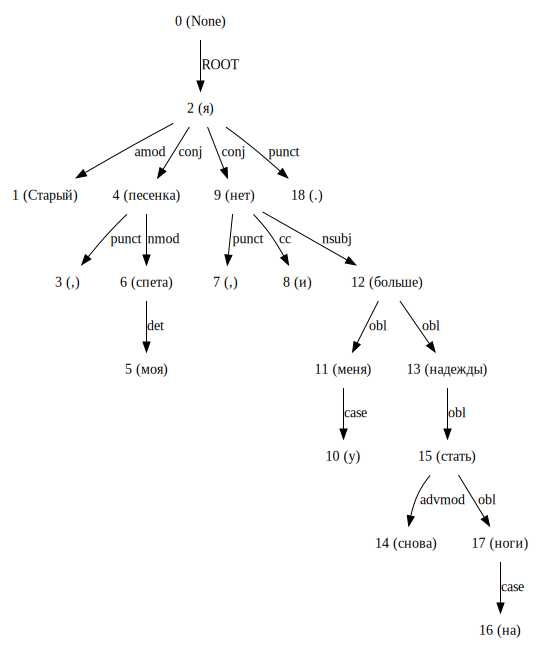

In [ ]:
examp_context = 'Старый я, песенка моя спета, и нет у меня больше надежды снова стать на ноги.'
examp_predicate = 'стать'

conllu = pipeline.process(examp_context)
graph = parse_to_graph(conllu)
graph

In [ ]:
from pprint import pprint
pprint(get_masked_sentences_for_words("стать", "Старый я, песенка моя спета, и нет у меня больше надежды снова стать на ноги"), 
       width=120, compact=True)

[['[CLS]', 'стар', '##ы', '##и', 'я', ',', 'песен', '##ка', 'моя', 'спе', '##та', ',', 'и', 'нет', 'у', 'меня',
  'больше', 'надежды', '[MASK]', 'стать', 'на', 'ноги', '[SEP]'],
 ['[CLS]', 'стар', '##ы', '##и', 'я', ',', 'песен', '##ка', 'моя', 'спе', '##та', ',', 'и', 'нет', 'у', 'меня',
  'больше', 'надежды', 'снова', 'стать', 'на', '[MASK]', '[SEP]']]


In [ ]:
masked_contexts_candidates = []
for row_ix, row in tqdm(contexts_trial_df.iterrows(), total=len(contexts_trial_df)):
    masked_sentences = get_masked_sentences_for_words(row["instance"], row["sentence"])
    for masked_sentence_tokenized in masked_sentences:
        new_row = deepcopy(row)
        new_row["sent_mask_tok"] = masked_sentence_tokenized
        new_row["sent_code"] = row_ix
        masked_contexts_candidates.append(new_row)

masked_contexts_candidates_df = pd.DataFrame(masked_contexts_candidates)
masked_contexts_candidates_df.head(2)

,instance,start,end,sentence,sent_mask_tok,sent_code
trial.sent.rus.0,стать,63,68,"Старый я, песенка моя спета, и нет у меня боль...","[[CLS], стар, ##ы, ##и, я, ,, песен, ##ка, моя...",trial.sent.rus.0
trial.sent.rus.0,стать,63,68,"Старый я, песенка моя спета, и нет у меня боль...","[[CLS], стар, ##ы, ##и, я, ,, песен, ##ка, моя...",trial.sent.rus.0


### Collecting BERT MLM mask candidates for each sentence

In [ ]:
def pad(pre_batch, pad_symbol):
    # adds padding to the begingn of the passed texts
    max_len = max(map(len, pre_batch))
    ress = [[pad_symbol]*(max_len-len(el)) + el for el in pre_batch]
    return ress


def top_n_tokens_in_mlm(probe_text_masked_tokenized_long_batch, N=1000):
    # tokenized (e.g. ['[CLS]', 'кошка', 'ест', 'карто', '##шку', '[MASK]'])
    # tokenized text transforms into a list of tokens [100, 123, 53, 213, 423, 100]]
    # and this happens with every item in the list of tokenized texts
    probe_text_masked_tokenized_long_batch = list(map(tokenizer.convert_tokens_to_ids,
                                                  probe_text_masked_tokenized_long_batch.tolist()))
    
    padded_batch = pad(probe_text_masked_tokenized_long_batch, tokenizer.pad_token_id)

    probe_text_masked_tokenized_long_batch = torch.LongTensor(padded_batch).to(DEVICE)
    outputs = model(input_ids=probe_text_masked_tokenized_long_batch)
    mask_token_indices = torch.where(probe_text_masked_tokenized_long_batch 
                                     == tokenizer.mask_token_id)  # про каждый элт батча на какой позиции в нём маска
    
    token_logits = outputs["logits"]    
    indices = torch.topk(token_logits[mask_token_indices],N).indices
    decoded = list(map(tokenizer.convert_ids_to_tokens, indices))
    
    return decoded

def indices_of_w_in_mlm(word_of_interest, probe_text_masked_tokenized, N=1000): #
    top_n_tokens = top_n_tokens_in_mlm(probe_text_masked_tokenized, N)

    return top_n_tokens.index(word_of_interest) if word_of_interest in top_n_tokens else -1

In [ ]:
batch_size = 32
col_to_process = masked_contexts_candidates_df["sent_mask_tok"]
n_batches = math.ceil(len(col_to_process) / batch_size)

preds_col = []
for batch in tqdm(np.array_split(col_to_process, n_batches)):
    preds_col.extend(top_n_tokens_in_mlm(batch, N=100))

masked_contexts_candidates_df["top words"] = preds_col

In [ ]:
sent2word2ix = defaultdict(lambda: defaultdict(list))
for row in masked_contexts_candidates_df.to_dict(orient="records"):
    for word_ix, word in enumerate(row["top words"]):
        sent2word2ix[row["sent_code"]][word].append(word_ix)

### Use MLM candidates to estimate sketches relevance for sentences

In [ ]:
def concatenate_lists(*lists):
    return list(itertools.chain(*lists))


def get_all_words_hypotheses(words_hypotheses_di, words_to_look_for):
    return concatenate_lists(words_hypotheses_di[word] for word in words_to_look_for)


def get_words_ixes(sketch_cell_text):
    sketch_cell_tokens = sketch_cell_text.split()

    return {sent_id: get_all_words_hypotheses(words_hypotheses_for_sent, sketch_cell_tokens)
            for sent_id, words_hypotheses_for_sent in sent2word2ix.items()}

In [ ]:
word2sentence_ix2freq = dict()
sketch_to_plot = dict()
for sketch_name, sketch in tqdm(sketches_dfs.items(), total=len(sketches_dfs)):
    cells = []
    for row_ix in sketch.index:
        for col_ix, colname in enumerate(sketch.columns):
            word = sketch[colname][row_ix]
            word_freqs = word2sentence_ix2freq.setdefault(word, get_words_ixes(word))
            cells.append((word, row_ix, col_ix, colname, word_freqs))
    
    sketch_to_plot[sketch_name] = cells

In [ ]:
cells_pretty = []
for sketch, cells in tqdm(sketch_to_plot.items(), total=len(sketch_to_plot)):
    for word, row_ix, col_ix, colname, word_freqs in cells:
        nrows_written = 0
        for sent, li in word_freqs.items():
            sent_text = contexts_trial_df.loc[sent]["sentence"]
            ok_sketch = sent2sketch.get(sent, '') == sketch
            base_sketch_di = {
                "word": word, 
                "row_ix": row_ix, "col_ix": col_ix, "colname": colname,
                "sent": sent, 
                "ix": "REPLACEME",
                "sketch": sketch,
                'predicted_sketch': sent2sketch.get(sent, ''),
                "sent_text": sent_text,
                "ok_sketch": ok_sketch
            }
            for el in li:
                el_sketch_di = base_sketch_di.copy()
                el_sketch_di["ix"] = el if el else pd.NA
                cells_pretty.append(el_sketch_di)
                nrows_written += 1
            if not li:
                sketch_di = base_sketch_di.copy()
                sketch_di["ix"] = pd.NA
                cells_pretty.append(sketch_di)
cells_df = pd.DataFrame(cells_pretty)

In [ ]:
cells_df.head(10)

,word,row_ix,col_ix,colname,sent,ix,sketch,predicted_sketch,sent_text,ok_sketch
0,в карты,0,0,Sphere_Special,trial.sent.rus.0,[34],trial.sketch.rus.0,trial.sketch.rus.8,"Старый я, песенка моя спета, и нет у меня боль...",False
1,в карты,0,0,Sphere_Special,trial.sent.rus.0,NaN,trial.sketch.rus.0,trial.sketch.rus.8,"Старый я, песенка моя спета, и нет у меня боль...",False
2,в карты,0,0,Sphere_Special,trial.sent.rus.1,"[16, 5]",trial.sketch.rus.0,trial.sketch.rus.4,Но не вызвала,False
3,в карты,0,0,Sphere_Special,trial.sent.rus.1,NaN,trial.sketch.rus.0,trial.sketch.rus.4,Но не вызвала,False
4,в карты,0,0,Sphere_Special,trial.sent.rus.2,"[63, 50, 40]",trial.sketch.rus.0,trial.sketch.rus.6,"А может, и вовсе поменяет конституцию и пойдет...",False
5,в карты,0,0,Sphere_Special,trial.sent.rus.2,NaN,trial.sketch.rus.0,trial.sketch.rus.6,"А может, и вовсе поменяет конституцию и пойдет...",False
6,в карты,0,0,Sphere_Special,trial.sent.rus.3,[8],trial.sketch.rus.0,trial.sketch.rus.2,"Я не стану отрекаться, – объяснил он",False
7,в карты,0,0,Sphere_Special,trial.sent.rus.3,NaN,trial.sketch.rus.0,trial.sketch.rus.2,"Я не стану отрекаться, – объяснил он",False
8,в карты,0,0,Sphere_Special,trial.sent.rus.4,"[74, 22, 24, 15]",trial.sketch.rus.0,trial.sketch.rus.15,В этом случае профиль сечения ППЭ реакции зави...,False
9,в карты,0,0,Sphere_Special,trial.sent.rus.4,NaN,trial.sketch.rus.0,trial.sketch.rus.15,В этом случае профиль сечения ППЭ реакции зави...,False


In [ ]:
cells_df.to_csv("cells_df.csv", index=False)

## Creating submission file and calculating accuracy on trial data

In [ ]:
cells_df = pd.read_csv("cells_df.csv")

In [ ]:
correctly_identified_sketches_num = 0
for sent_text, sent_sks_df in cells_df.groupby(by=["sent_text"]):
    sketches_skores = sent_sks_df.dropna().groupby(by="sketch")\
                    .agg({"ix": "count", "ok_sketch": "first"})
    if sketches_skores.nlargest(1, "ix").ok_sketch.any():
        correctly_identified_sketches_num += 1

In [ ]:
print('Accuracy on a trial data:', correctly_identified_sketches_num / 2000)

Accuracy on a trial data: 0.1535


In [ ]:
# Saving answers in the submission format
import json

predictions_df = cells_df[['sent', 'predicted_sketch']].copy()
predict_dict = predictions_df.set_index('sent').to_dict()['predicted_sketch']
predict_json = json.dumps(predict_dict)

##  Sketches scores visualization
(see viz.pdf for results)

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(ggplot2)
library(dplyr)
library(stringr)

mytable<-read.csv("cells_df.csv",header=TRUE,stringsAsFactors=FALSE)

cairo_pdf("viz.pdf", family="DejaVu Sans", onefile=T)
for (sent_code in head(unique(mytable$sent), 2)){
    first_sent = mytable[mytable$sent == sent_code,]
    print(paste(sent_code, "done"))

    for (curr_sketch_name in unique(first_sent$sketch_pretty_name)) { 
        sketch_df = first_sent[(first_sent$sketch_pretty_name == curr_sketch_name),]
        sketch_name = sketch_df$sketch[1]
        sent_text = sketch_df$sent_text[1]

        color = ifelse(sketch_df$ok_sketch[1] == "True", "lightgreen", "lightpink")
        # print(nrow(sketch_df[!is.na(sketch_df$ix) ,]) == 0,)
        if(nrow(sketch_df[!is.na(sketch_df$ix) ,]) == 0){
        }else{
            fig = sketch_df %>% ggplot(aes(x=ix)) +
            xlim(0,1000) + ylim(0,10) +  # all the histograms will share these axes limits 
            geom_histogram(bins=10) +  # all the histograms will be of 10 bins
            facet_grid(row_ix ~ colname) + 
            labs(title=paste(curr_sketch_name, sketch_name), subtitle = sent_text) + 
            geom_text(data = sketch_df,
                      mapping = aes(x = 500, y = 4,  # 500, 4 is nearly the center of the histogram
                                    label = word %>% str_replace_all('[\\s-]', '\n')),
                      size=2) +  # size stands for fontsize
            theme(strip.background = element_rect(fill=color),
                  axis.text.x = element_text(angle = 90, hjust = 1))  # rotate x-ticks
        
            print(fig)  # prints as another page to PDF
        }
    }
}

dev.off()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] "trial.sent.rus.0 done"
[1] "trial.sent.rus.1 done"
png 
  2 
